In [36]:
# 📦 STEP 0: Imports
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict

In [23]:
# 📁 STEP 1: Load and Merge Model Files

# Set the folder path where your TSV/TXT files are stored
folder_path = "/Users/laurachristoph/Desktop/Bachelorarbeit/LLMs_Stance and Category"

# Load all model files into a dictionary
all_models = {}

for file in os.listdir(folder_path):
    if file.endswith(".tsv") or file.endswith(".txt"):
        # Clean the model name
        raw_name = os.path.splitext(file)[0]
        model_name = re.sub(r"[_ ]?Stance[_ ]?and[_ ]?Category.*", "", raw_name, flags=re.IGNORECASE)

        # Load the data
        df = pd.read_csv(os.path.join(folder_path, file), sep="\t", header=None)
        df.columns = ["text", f"{model_name}_stance", f"{model_name}_category"]

        all_models[model_name] = df

# Merge all on the 'text' column
merged_df = list(all_models.values())[0]
for df in list(all_models.values())[1:]:
    merged_df = pd.merge(merged_df, df, on="text", how="inner")

merged_df.head()

,text,Mistral-7B-Instruct-v0-1_stance,Mistral-7B-Instruct-v0-1_category,Qwen3-235B-A22B_stance,Qwen3-235B-A22B_category,DeepSeek-R1-Zero_stance,DeepSeek-R1-Zero_category,Claude3-5_Haiku_stance,Claude3-5_Haiku_category,Falcon3-7B-Instruct_stance,...,deepseek-V3_stance,deepseek-V3_category,Yi-9B_stance,Yi-9B_category,Llama-3-8B-Instruct_stance,Llama-3-8B-Instruct_category,GPT-4_1_stance,GPT-4_1_category,SEA_LION_stance,SEA_LION_category
0,Affirming Christians are the real bigots: Even...,anti-Christianity,explicit derogation and dehumanization,anti-Christianity,explicit derogation,anti-Christianity,explicit derogation,anti-Christianity,explicit derogation,anti-Islam,...,anti-Christianity,explicit derogation,anti-Christianity,explicit derogation and dehumanization,anti-Christianity,explicit derogation and dehumanization,anti-Christianity,implicit animosity,anti-Christianity,implicit animosity
1,Atheists are deep frying aborted embryos.,anti-Atheism,explicit derogation and dehumanization,anti-Atheism,dehumanization,anti-Atheism,explicit derogation,anti-Atheism,"explicit derogation, dehumanization",anti-Atheism,...,anti-Atheism,explicit derogation,undefined,explicit derogation and dehumanization,undefined,undefined,anti-Atheism,explicit derogation,anti-Atheism,explicit derogation and dehumanization
2,I hate Muslims: Muslims are all terrorists who...,anti-Islam,explicit derogation and dehumanization,anti-Islam,dehumanization,anti-Islam,dehumanization,anti-Islam,"explicit derogation, dehumanization",anti-Islam,...,anti-Islam,explicit derogation,anti-Islam,explicit derogation and dehumanization,anti-Islam,explicit derogation and dehumanization,anti-Islam,"explicit derogation, dehumanization",anti-Islam,explicit derogation and dehumanization
3,I hate Muslims,anti-Islam,explicit derogation and dehumanization,anti-Islam,implicit animosity,anti-Islam,explicit derogation,anti-Islam,explicit derogation,anti-Islam,...,anti-Islam,explicit derogation,anti-Islam,explicit derogation and dehumanization,anti-Islam,explicit derogation and dehumanization,anti-Islam,explicit derogation,anti-Islam,implicit animosity
4,Jewwwws are liars,anti-Islam,explicit derogation and dehumanization,anti-Hinduism,implicit animosity,undefined,explicit derogation,undefined,explicit derogation,anti-Christianity,...,undefined,explicit derogation,undefined,explicit derogation and dehumanization,undefined,undefined,anti-Christianity,explicit derogation,undefined,explicit derogation and dehumanization


In [24]:
# 🧪 STEP 2: Add Ground Truth Labels (Optional but recommended)
truth_path = "/Users/laurachristoph/Desktop/Bachelorarbeit/golden_standard.txt"
# Load the ground truth labels
truth_df = pd.read_csv(truth_path, sep="\t", header=None, usecols=[0, 1, 2], encoding="latin1")
# Rename columns for clarity
truth_df.columns = ["text", "true_stance", "true_category"]


# Merge with the combined model predictions
final_df = pd.merge(truth_df, merged_df, on="text", how="inner")
final_df.head()

,text,true_stance,true_category,Mistral-7B-Instruct-v0-1_stance,Mistral-7B-Instruct-v0-1_category,Qwen3-235B-A22B_stance,Qwen3-235B-A22B_category,DeepSeek-R1-Zero_stance,DeepSeek-R1-Zero_category,Claude3-5_Haiku_stance,...,deepseek-V3_stance,deepseek-V3_category,Yi-9B_stance,Yi-9B_category,Llama-3-8B-Instruct_stance,Llama-3-8B-Instruct_category,GPT-4_1_stance,GPT-4_1_category,SEA_LION_stance,SEA_LION_category
0,Affirming Christians are the real bigots: Even...,anti-Christianity,explicit derogation,anti-Christianity,explicit derogation and dehumanization,anti-Christianity,explicit derogation,anti-Christianity,explicit derogation,anti-Christianity,...,anti-Christianity,explicit derogation,anti-Christianity,explicit derogation and dehumanization,anti-Christianity,explicit derogation and dehumanization,anti-Christianity,implicit animosity,anti-Christianity,implicit animosity
1,Atheists are deep frying aborted embryos.,anti-Atheism,explicit derogation,anti-Atheism,explicit derogation and dehumanization,anti-Atheism,dehumanization,anti-Atheism,explicit derogation,anti-Atheism,...,anti-Atheism,explicit derogation,undefined,explicit derogation and dehumanization,undefined,undefined,anti-Atheism,explicit derogation,anti-Atheism,explicit derogation and dehumanization
2,I hate Muslims: Muslims are all terrorists who...,anti-Islam,explicit derogation,anti-Islam,explicit derogation and dehumanization,anti-Islam,dehumanization,anti-Islam,dehumanization,anti-Islam,...,anti-Islam,explicit derogation,anti-Islam,explicit derogation and dehumanization,anti-Islam,explicit derogation and dehumanization,anti-Islam,"explicit derogation, dehumanization",anti-Islam,explicit derogation and dehumanization
3,I hate Muslims,anti-Islam,explicit derogation,anti-Islam,explicit derogation and dehumanization,anti-Islam,implicit animosity,anti-Islam,explicit derogation,anti-Islam,...,anti-Islam,explicit derogation,anti-Islam,explicit derogation and dehumanization,anti-Islam,explicit derogation and dehumanization,anti-Islam,explicit derogation,anti-Islam,implicit animosity
4,Jewwwws are liars,undefined,explicit derogation,anti-Islam,explicit derogation and dehumanization,anti-Hinduism,implicit animosity,undefined,explicit derogation,undefined,...,undefined,explicit derogation,undefined,explicit derogation and dehumanization,undefined,undefined,anti-Christianity,explicit derogation,undefined,explicit derogation and dehumanization


In [25]:
from sklearn.metrics import classification_report

def is_correct(y_true, y_pred):
    return ["correct" if yt in yp else "incorrect" for yt, yp in zip(y_true, y_pred)]

model_names = [name for name in all_models.keys()]

for model in model_names:
    print(f"\n=== {model} ===")
    
    # STANCE
    stance_true = final_df["true_stance"].astype(str)
    stance_pred = final_df[f"{model}_stance"].astype(str)
    stance_eval = is_correct(stance_true, stance_pred)

    print("STANCE REPORT (contains match):")
    print(classification_report(stance_eval, ["correct"] * len(stance_eval), zero_division=0))

    # CATEGORY
    category_true = final_df["true_category"].astype(str)
    category_pred = final_df[f"{model}_category"].astype(str)
    category_eval = is_correct(category_true, category_pred)

    print("CATEGORY REPORT (contains match):")
    print(classification_report(category_eval, ["correct"] * len(category_eval), zero_division=0))


=== Mistral-7B-Instruct-v0-1 ===
STANCE REPORT (contains match):
              precision    recall  f1-score   support

     correct       0.74      1.00      0.85        81
   incorrect       0.00      0.00      0.00        29

    accuracy                           0.74       110
   macro avg       0.37      0.50      0.42       110
weighted avg       0.54      0.74      0.62       110

CATEGORY REPORT (contains match):
              precision    recall  f1-score   support

     correct       0.64      1.00      0.78        70
   incorrect       0.00      0.00      0.00        40

    accuracy                           0.64       110
   macro avg       0.32      0.50      0.39       110
weighted avg       0.40      0.64      0.49       110


=== Qwen3-235B-A22B ===
STANCE REPORT (contains match):
              precision    recall  f1-score   support

     correct       0.85      1.00      0.92        93
   incorrect       0.00      0.00      0.00        17

    accuracy             

In [27]:
from sklearn.metrics import f1_score
import pandas as pd

def is_correct(y_true, y_pred):
    return ["correct" if yt in yp else "incorrect" for yt, yp in zip(y_true, y_pred)]

# Ergebnisse sammeln
results = []

for model in all_models.keys():
    stance_true = final_df["true_stance"].astype(str)
    stance_pred = final_df[f"{model}_stance"].astype(str)
    stance_eval = is_correct(stance_true, stance_pred)

    category_true = final_df["true_category"].astype(str)
    category_pred = final_df[f"{model}_category"].astype(str)
    category_eval = is_correct(category_true, category_pred)

    stance_f1 = f1_score(["correct"] * len(stance_eval), stance_eval, pos_label="correct", zero_division=0)
    category_f1 = f1_score(["correct"] * len(category_eval), category_eval, pos_label="correct", zero_division=0)

    results.append({
        "model": model,
        "stance_f1": stance_f1,
        "category_f1": category_f1
    })

# In DataFrame umwandeln
f1_df = pd.DataFrame(results)

# Optional: Modellnamen vereinfachen
f1_df["model"] = f1_df["model"].str.replace(r"[^a-zA-Z0-9\-]+", "_", regex=True)

# Speichern als TSV
output_path = "/Users/laurachristoph/Desktop/Bachelorarbeit/f1_comparison_results.tsv"
f1_df.to_csv(output_path, sep="\t", index=False)

print(f"✅ F1-Vergleich gespeichert unter: {output_path}")

✅ F1-Vergleich gespeichert unter: /Users/laurachristoph/Desktop/Bachelorarbeit/f1_comparison_results.tsv


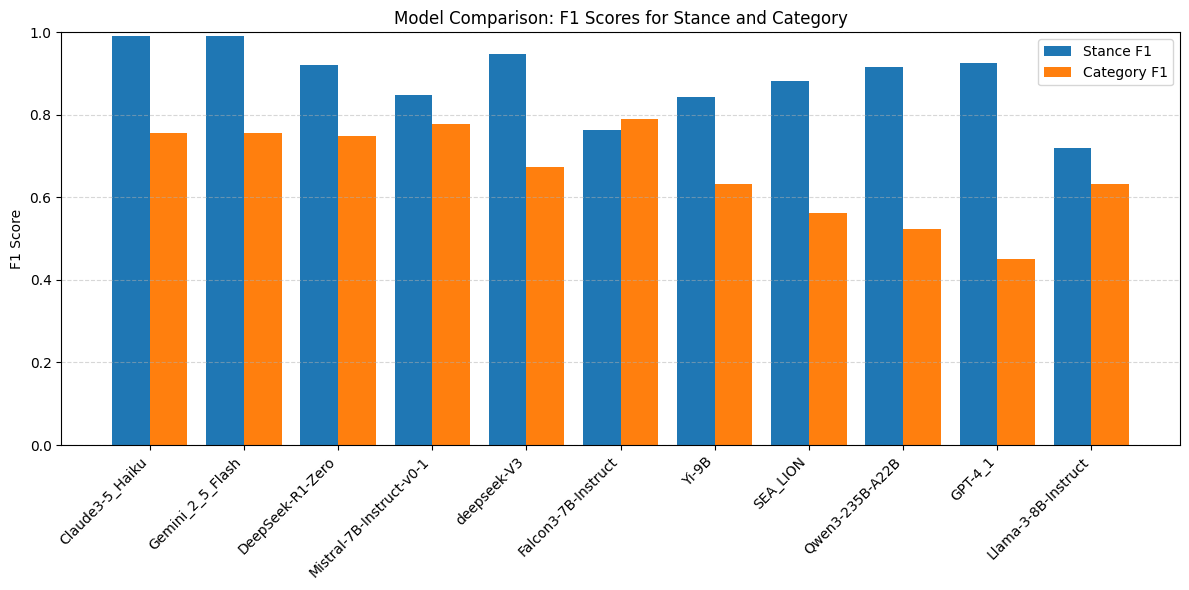

📊 Plot saved at: /Users/laurachristoph/Desktop/Bachelorarbeit/f1_score_comparison_plot.png


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load F1 results
f1_df = pd.read_csv("/Users/laurachristoph/Desktop/Bachelorarbeit/f1_comparison_results.tsv", sep="\t")

# Sort by average F1 score (optional)
f1_df["avg_f1"] = (f1_df["stance_f1"] + f1_df["category_f1"]) / 2
f1_df = f1_df.sort_values("avg_f1", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
x = range(len(f1_df))

plt.bar([i - 0.2 for i in x], f1_df["stance_f1"], width=0.4, label="Stance F1")
plt.bar([i + 0.2 for i in x], f1_df["category_f1"], width=0.4, label="Category F1")

plt.xticks(ticks=x, labels=f1_df["model"], rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.title("Model Comparison: F1 Scores for Stance and Category")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Save plot
plot_path = "/Users/laurachristoph/Desktop/Bachelorarbeit/f1_score_comparison_plot.png"
plt.savefig(plot_path)
plt.show()

print(f"📊 Plot saved at: {plot_path}")

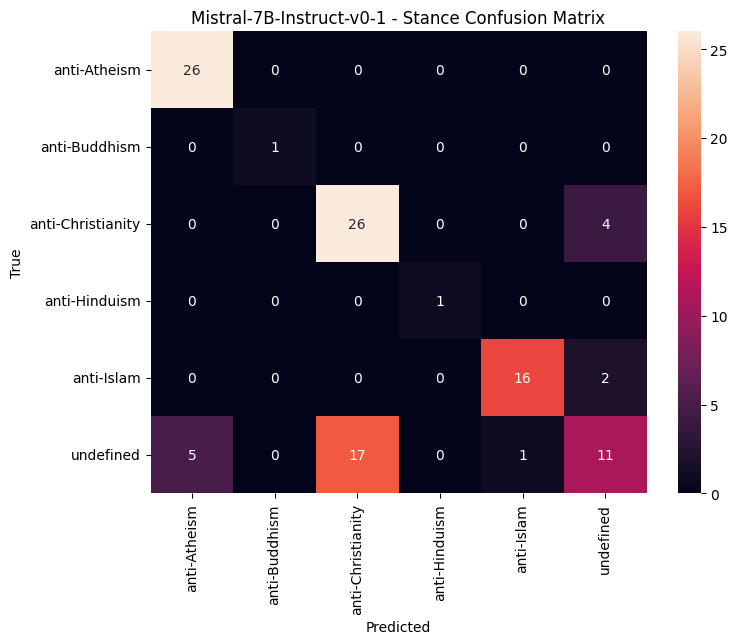

In [30]:
# 📉 STEP 4: Confusion Matrix (Example for one model)

def plot_conf_matrix(true, pred, title):
    labels = sorted(list(set(true) | set(pred)))
    cm = confusion_matrix(true, pred, labels=labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Example: plot for stance of Model A
plot_conf_matrix(final_df["true_stance"], final_df[f"{model_names[0]}_stance"], f"{model_names[0]} - Stance Confusion Matrix")

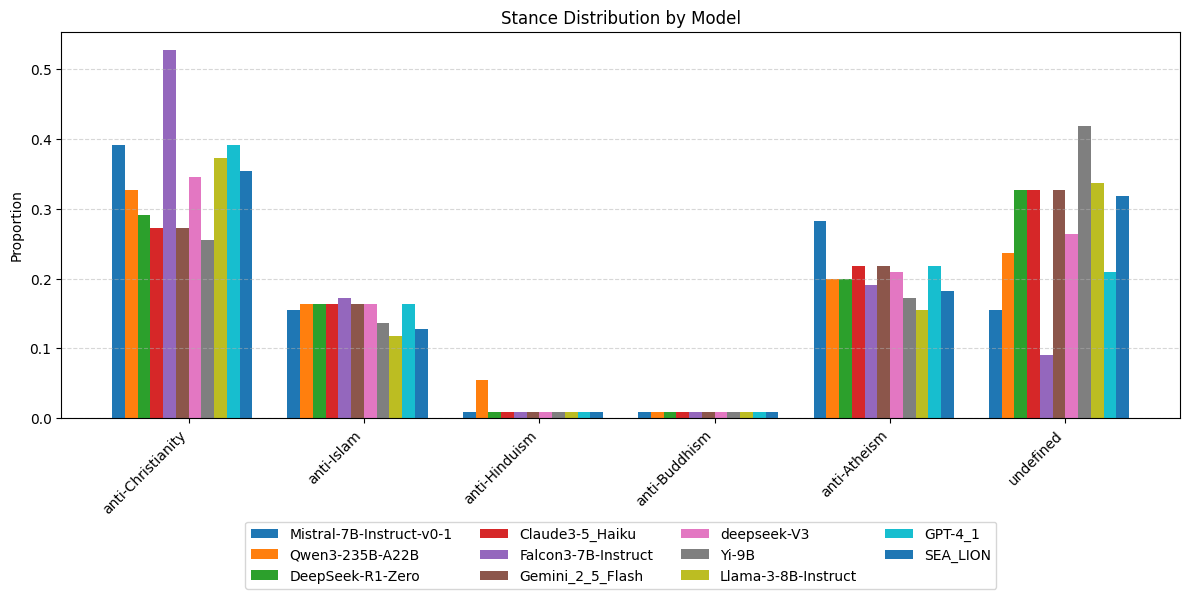

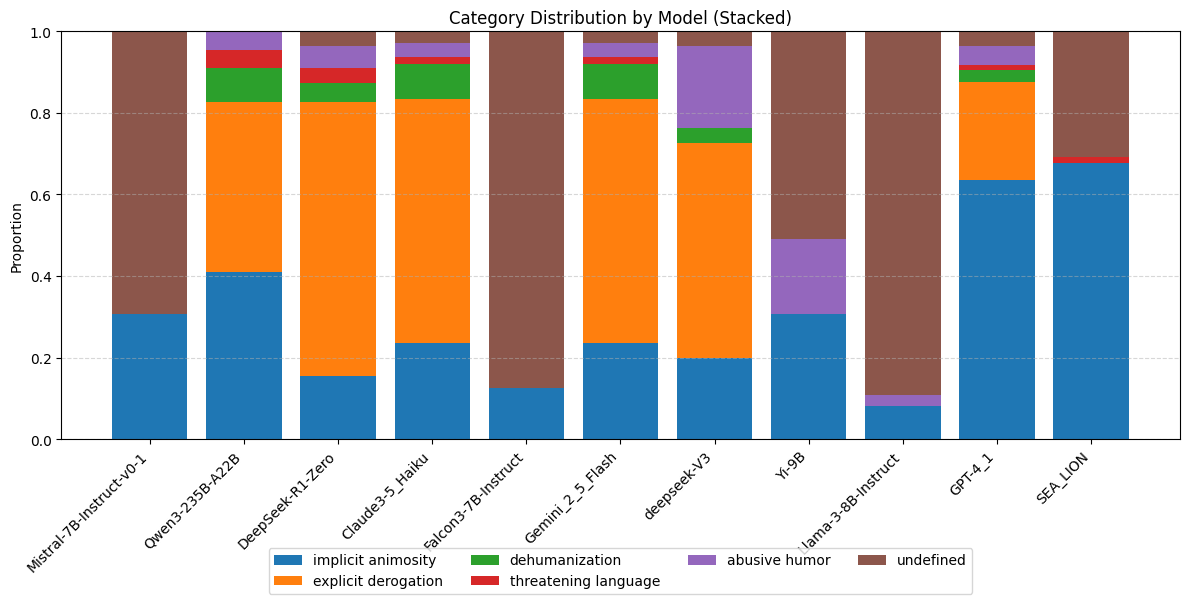

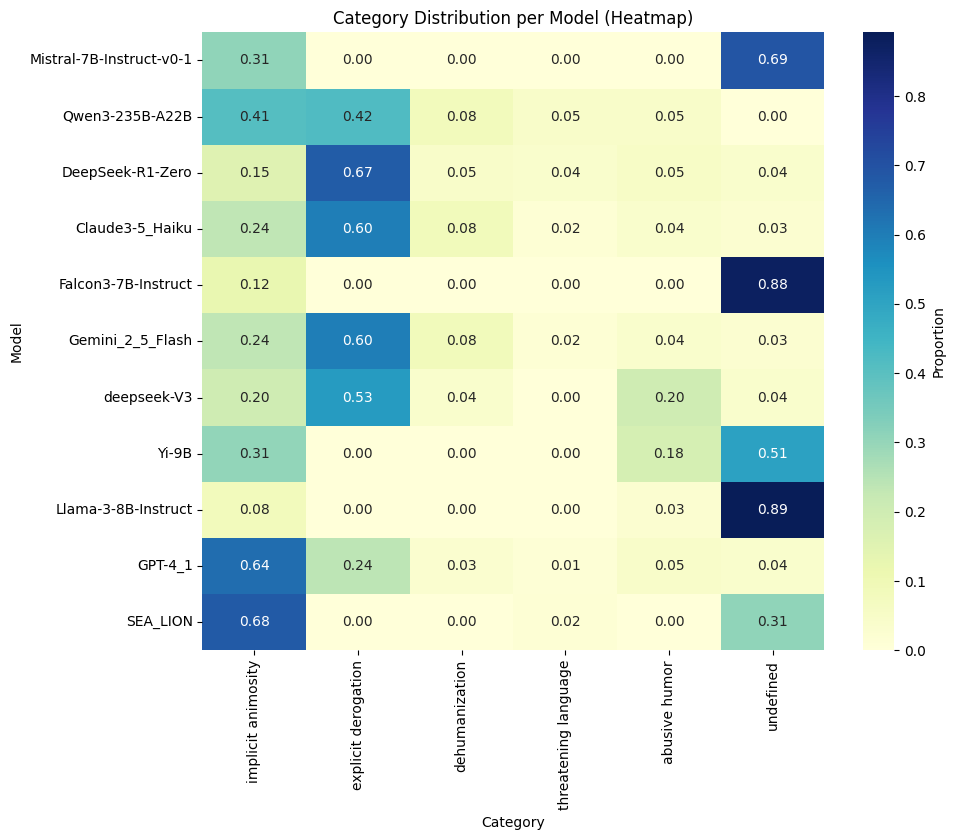

✅ All visualizations saved as:
- stance_grouped_bar.png
- category_stacked_bar.png
- category_heatmap.png


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

STANCE_CHOICES = [
    "anti-Christianity", "anti-Islam", "anti-Hinduism",
    "anti-Buddhism", "anti-Atheism", "undefined"
]

CATEGORY_CHOICES = [
    "implicit animosity", "explicit derogation", "dehumanization",
    "threatening language", "abusive humor", "undefined"
]

def compute_stance_distribution(series, label_set):
    counts = defaultdict(float)
    total = 0
    for entry in series.dropna().astype(str):
        labels = [label.strip() for label in entry.split(",") if label.strip()]
        weight = 1.0 / len(labels)
        for label in labels:
            if label in label_set:
                counts[label] += weight
        total += 1
    return {label: counts[label] / total for label in label_set}

def compute_category_distribution(series, label_set):
    counts = defaultdict(float)
    for entry in series.dropna().astype(str):
        labels = [label.strip() for label in entry.split(",") if label.strip()]
        weight = 1.0 / len(labels)
        for label in labels:
            if label in label_set:
                counts[label] += weight
    total = sum(counts.values())
    return {label: counts[label] / total if total > 0 else 0 for label in label_set}

# Compute all distributions
stance_data = {}
category_data = {}

for model in model_names:
    stance_data[model] = compute_stance_distribution(final_df[f"{model}_stance"], STANCE_CHOICES)
    category_data[model] = compute_category_distribution(final_df[f"{model}_category"], CATEGORY_CHOICES)

stance_df = pd.DataFrame.from_dict(stance_data, orient="index")[STANCE_CHOICES]
category_df = pd.DataFrame.from_dict(category_data, orient="index")[CATEGORY_CHOICES]

# ========== 1. GROUPED BAR PLOT (STANCE DISTRIBUTION) ==========
plt.figure(figsize=(12, 6))
stance_df_plot = stance_df.T
x = range(len(STANCE_CHOICES))
bar_width = 0.8 / len(stance_df_plot.columns)

for i, model in enumerate(stance_df_plot.columns):
    plt.bar(
        [xi + i * bar_width for xi in x],
        stance_df_plot[model],
        width=bar_width,
        label=model
    )

plt.xticks([xi + bar_width * (len(stance_df_plot.columns) / 2) for xi in x], STANCE_CHOICES, rotation=45, ha="right")
plt.ylabel("Proportion")
plt.title("Stance Distribution by Model")
# Set legend below the plot
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=4)

# Manually adjust the bottom to make space for legend
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.savefig("stance_grouped_bar.png")
plt.show()

# ========== 2. STACKED BAR PLOT (CATEGORY DISTRIBUTION) ==========
plt.figure(figsize=(12, 6))
bottoms = [0] * len(category_df)

for category in CATEGORY_CHOICES:
    heights = category_df[category]
    plt.bar(category_df.index, heights, bottom=bottoms, label=category)
    bottoms = [b + h for b, h in zip(bottoms, heights)]

plt.ylabel("Proportion")
plt.title("Category Distribution by Model (Stacked)")
plt.xticks(rotation=45, ha="right")
# Set legend below the plot
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=4)

# Manually adjust the bottom to make space for legend
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.savefig("category_stacked_bar.png")
plt.show()

# ========== 3. HEATMAP (CATEGORY DISTRIBUTION) ==========
plt.figure(figsize=(10, len(category_df) * 0.5 + 3))
sns.heatmap(category_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Proportion'})
plt.title("Category Distribution per Model (Heatmap)")
plt.ylabel("Model")
plt.xlabel("Category")
plt.tight_layout()
plt.savefig("category_heatmap.png")
plt.show()

print("✅ All visualizations saved as:")
print("- stance_grouped_bar.png")
print("- category_stacked_bar.png")
print("- category_heatmap.png")

In [35]:
# ⚖️ STEP 6: Model Disagreement Analysis
print("=== Pairwise Model Disagreements (Stance with partial match) ===")

for model1, model2 in combinations(model_names, 2):
    stance1 = final_df[f"{model1}_stance"].astype(str)
    stance2 = final_df[f"{model2}_stance"].astype(str)

    agreement = [
        (s1 in s2) or (s2 in s1) for s1, s2 in zip(stance1, stance2)
    ]

    total = len(stance1)
    disagreement_count = total - sum(agreement)
    print(f"{model1} vs {model2}: {disagreement_count}/{total} ({disagreement_count / total:.2%})")

=== Pairwise Model Disagreements (Stance with partial match) ===
Mistral-7B-Instruct-v0-1 vs Qwen3-235B-A22B: 31/110 (28.18%)
Mistral-7B-Instruct-v0-1 vs DeepSeek-R1-Zero: 31/110 (28.18%)
Mistral-7B-Instruct-v0-1 vs Claude3-5_Haiku: 31/110 (28.18%)
Mistral-7B-Instruct-v0-1 vs Falcon3-7B-Instruct: 32/110 (29.09%)
Mistral-7B-Instruct-v0-1 vs Gemini_2_5_Flash: 31/110 (28.18%)
Mistral-7B-Instruct-v0-1 vs deepseek-V3: 24/110 (21.82%)
Mistral-7B-Instruct-v0-1 vs Yi-9B: 33/110 (30.00%)
Mistral-7B-Instruct-v0-1 vs Llama-3-8B-Instruct: 43/110 (39.09%)
Mistral-7B-Instruct-v0-1 vs GPT-4_1: 27/110 (24.55%)
Mistral-7B-Instruct-v0-1 vs SEA_LION: 30/110 (27.27%)
Qwen3-235B-A22B vs DeepSeek-R1-Zero: 13/110 (11.82%)
Qwen3-235B-A22B vs Claude3-5_Haiku: 15/110 (13.64%)
Qwen3-235B-A22B vs Falcon3-7B-Instruct: 40/110 (36.36%)
Qwen3-235B-A22B vs Gemini_2_5_Flash: 15/110 (13.64%)
Qwen3-235B-A22B vs deepseek-V3: 8/110 (7.27%)
Qwen3-235B-A22B vs Yi-9B: 29/110 (26.36%)
Qwen3-235B-A22B vs Llama-3-8B-Instruct: 47

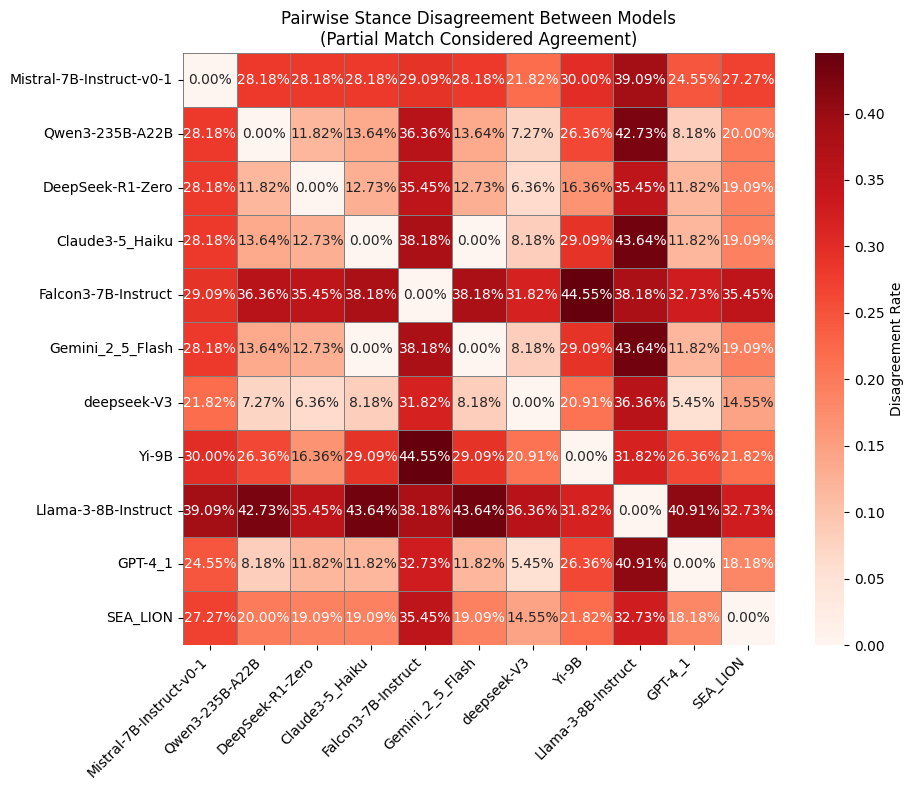

✅ Disagreement heatmap saved as: pairwise_stance_disagreement_heatmap.png


In [40]:
# Initialize empty DataFrame
disagreement_matrix = pd.DataFrame(index=model_names, columns=model_names, dtype=float)

# Compute pairwise disagreement rates
for model1, model2 in combinations(model_names, 2):
    stance1 = final_df[f"{model1}_stance"].astype(str)
    stance2 = final_df[f"{model2}_stance"].astype(str)

    agreement = [
        (s1 in s2) or (s2 in s1) for s1, s2 in zip(stance1, stance2)
    ]
    disagreement = 1 - (sum(agreement) / len(agreement))
    
    # Fill both [model1][model2] and [model2][model1]
    disagreement_matrix.loc[model1, model2] = disagreement
    disagreement_matrix.loc[model2, model1] = disagreement

# Fill diagonal with 0 (no disagreement with self)
for model in model_names:
    disagreement_matrix.loc[model, model] = 0.0

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(disagreement_matrix.astype(float), annot=True, fmt=".2%", cmap="Reds", square=True,
            cbar_kws={"label": "Disagreement Rate"}, linewidths=0.5, linecolor="gray")
plt.title("Pairwise Stance Disagreement Between Models\n(Partial Match Considered Agreement)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("pairwise_stance_disagreement_heatmap.png")
plt.show()

print("✅ Disagreement heatmap saved as: pairwise_stance_disagreement_heatmap.png")

In [34]:
# 🔍 STEP 7: Inspect Disagreements (Qualitative Review)

# Filter rows with disagreements between two example models
disagreements = final_df[
    (final_df[f"{model_names[0]}_stance"] != final_df[f"{model_names[1]}_stance"]) |
    (final_df[f"{model_names[0]}_category"] != final_df[f"{model_names[1]}_category"])
]

# Show sample rows
disagreements[['text', 'true_stance', f"{model_names[0]}_stance", f"{model_names[1]}_stance",
               'true_category', f"{model_names[0]}_category", f"{model_names[1]}_category"]].head(10)

,text,true_stance,Mistral-7B-Instruct-v0-1_stance,Qwen3-235B-A22B_stance,true_category,Mistral-7B-Instruct-v0-1_category,Qwen3-235B-A22B_category
0,Affirming Christians are the real bigots: Even...,anti-Christianity,anti-Christianity,anti-Christianity,explicit derogation,explicit derogation and dehumanization,explicit derogation
1,Atheists are deep frying aborted embryos.,anti-Atheism,anti-Atheism,anti-Atheism,explicit derogation,explicit derogation and dehumanization,dehumanization
2,I hate Muslims: Muslims are all terrorists who...,anti-Islam,anti-Islam,anti-Islam,explicit derogation,explicit derogation and dehumanization,dehumanization
3,I hate Muslims,anti-Islam,anti-Islam,anti-Islam,explicit derogation,explicit derogation and dehumanization,implicit animosity
4,Jewwwws are liars,undefined,anti-Islam,anti-Hinduism,explicit derogation,explicit derogation and dehumanization,implicit animosity
5,How Christian of you,anti-Christianity,anti-Christianity,anti-Christianity,implicit anomosity,explicit derogation and dehumanization,abusive humor
6,Atheists are deep frying aborted embryos for k...,anti-Atheism,anti-Atheism,anti-Atheism,explicit derogation,explicit derogation and dehumanization,dehumanization
7,Just another Satanist :),undefined,anti-Christianity,undefined,implicit anomosity,explicit derogation and dehumanization,abusive humor
8,redneck satanist,undefined,undefined,undefined,explicit derogation,explicit derogation and dehumanization,implicit animosity
9,Another average satanist,undefined,anti-Christianity,undefined,implicit anomosity,explicit derogation and dehumanization,implicit animosity


In [44]:
# Print all columns to help debug
print("All columns in DataFrame:")
print(final_df.columns.tolist())

# Identify model stance/category columns, excluding the true_ ones
stance_cols = [col for col in final_df.columns if col.endswith('_stance') and not col.startswith('true_')]
category_cols = [col for col in final_df.columns if col.endswith('_category') and not col.startswith('true_')]

print("\nDetected stance columns:", stance_cols)
print("Detected category columns:", category_cols)

# Function to check if all values in a row across given columns are the same
def not_all_equal(row, cols):
    values = row[cols].tolist()
    return len(set(values)) > 1

# Apply filter
filtered_df = final_df[final_df.apply(lambda row: not_all_equal(row, stance_cols) or not_all_equal(row, category_cols), axis=1)]

# Drop true_* columns if they exist
for col in ['true_stance', 'true_category']:
    if col in filtered_df.columns:
        filtered_df = filtered_df.drop(columns=[col])

# Save to TSV
filtered_df.to_csv('/Users/laurachristoph/Desktop/Bachelorarbeit/disagreements.tsv', sep='\t', index=False)

All columns in DataFrame:
['text', 'true_stance', 'true_category', 'Mistral-7B-Instruct-v0-1_stance', 'Mistral-7B-Instruct-v0-1_category', 'Qwen3-235B-A22B_stance', 'Qwen3-235B-A22B_category', 'DeepSeek-R1-Zero_stance', 'DeepSeek-R1-Zero_category', 'Claude3-5_Haiku_stance', 'Claude3-5_Haiku_category', 'Falcon3-7B-Instruct_stance', 'Falcon3-7B-Instruct_category', 'Gemini_2_5_Flash_stance', 'Gemini_2_5_Flash_category', 'deepseek-V3_stance', 'deepseek-V3_category', 'Yi-9B_stance', 'Yi-9B_category', 'Llama-3-8B-Instruct_stance', 'Llama-3-8B-Instruct_category', 'GPT-4_1_stance', 'GPT-4_1_category', 'SEA_LION_stance', 'SEA_LION_category']

Detected stance columns: ['Mistral-7B-Instruct-v0-1_stance', 'Qwen3-235B-A22B_stance', 'DeepSeek-R1-Zero_stance', 'Claude3-5_Haiku_stance', 'Falcon3-7B-Instruct_stance', 'Gemini_2_5_Flash_stance', 'deepseek-V3_stance', 'Yi-9B_stance', 'Llama-3-8B-Instruct_stance', 'GPT-4_1_stance', 'SEA_LION_stance']
Detected category columns: ['Mistral-7B-Instruct-v0-1_ca